In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import librosa
# DATA_ROOT = "F:/DATAS/NEUCOUGHDATA_COUGH/"
DATA_ROOT = "E:/DATAS-Medical/BILIBILICOUGH/"
fname = "bilicough_004"

In [2]:
def min2sec(t: str):
    parts = t.split(':')
    return int(parts[1]) * 60 + float(parts[2])

def read_ass_to_segs(asspath):
    fin = open(asspath, 'r', encoding="UTF-8")
    line = fin.readline()
    while line:
        if line[:8]!="Dialogue":
            line = fin.readline()
        else:
            break
    intervals = []
#     line = fin.readline()
    while line:
        parts = line.strip().split(',')
        # print(parts[1], parts[2], parts[-1])
        intervals.append((min2sec(parts[1]), min2sec(parts[2])))
        line = fin.readline()
    fin.close()
    return intervals

number of annotations:15.


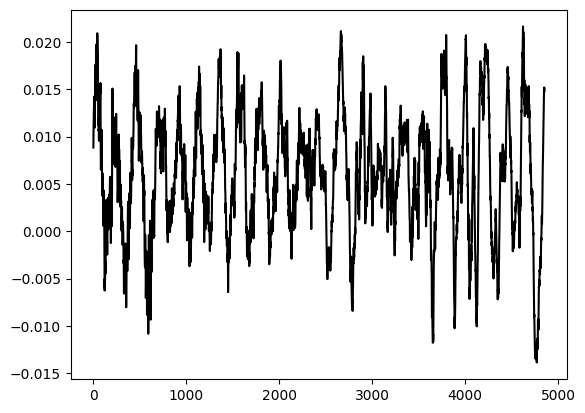

In [4]:
ass_test_path = os.path.join(DATA_ROOT, fname+".ass")
intervals = read_ass_to_segs(ass_test_path)
print("number of annotations:{}.".format(len(intervals)))
ind = 4

wav_test_path = os.path.join(DATA_ROOT, fname+".wav")
y, sr = librosa.load(wav_test_path)
st_test, en_test = int(intervals[ind][0]*sr), int(intervals[ind][1]*sr)+1
y_show = y[st_test:en_test]
plt.figure(0)
plt.plot(range(len(y_show)), y_show, c="#000000")
# plt.close(0)

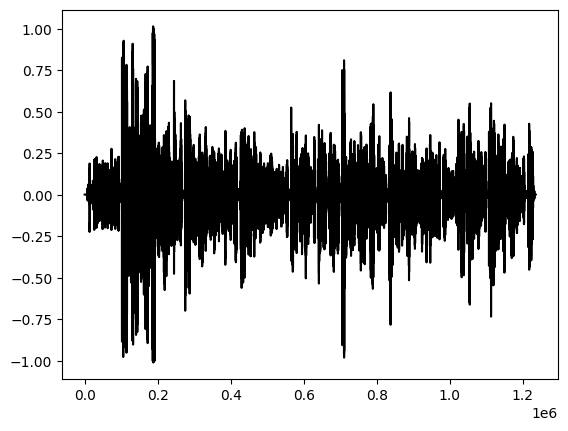

In [5]:
plt.figure(1)
plt.plot(range(len(y)), y, c="#000000")

In [ ]:
# import sys
# sys.path.append(r'D:/PythonTorchVITS/MedicalSignal/SoundDL-CoughVID')
import torch
import torchaudio
class Wave2Mel(object):
    def __init__(self, sr,
                 n_fft=1024,
                 n_mels=128,
                 win_length=1024,
                 hop_length=512,
                 power=2.0
                 ):
        self.mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                                                  win_length=win_length,
                                                                  hop_length=hop_length,
                                                                  n_fft=n_fft,
                                                                  n_mels=n_mels,
                                                                  power=power)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(stype='power')

    def __call__(self, x):
        return self.amplitude_to_db(self.mel_transform(x))
w2m = Wave2Mel(sr=sr)
neg_mel = w2m(torch.from_numpy(y).to(torch.float32))
neg_mel = neg_mel.data.cpu().numpy().astype(np.uint8)
print(neg_mel.shape)
plt.figure(2)
plt.imshow(neg_mel)

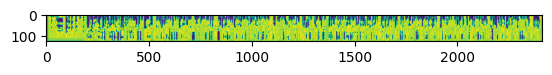

## 读取meta文件的一些列

In [ ]:
def get_attributes(name_list, filename):
    # name_list = ["gender", "issmoking", "isalcohol", "iscough", "isfever", "isrespill", "iscovid19"]
    json_str = None  # json string
    with open(filename, 'r', encoding='utf_8') as fp:
        json_str = fp.read()
    json_data = json.loads(json_str)  # get json from json string
    res = []
    for name in name_list:
        res.append(json_data[name])
    return res

def get_answers(idx_list, filename):
    idxrange = [1, 9, 17, 24, 32, 40, 47, 54, 61]
    idxmapper = {}
    for i in range(len(idxrange)-1):
        for j in range(idxrange[i], idxrange[i+1]):
            idxmapper[j] = idxrange[i]
    json_str = None  # json string
    with open(filename, 'r', encoding='utf_8') as fp:
        json_str = fp.read()
    json_data = json.loads(json_str)  # get json from json string
    
    consti_mapper = {0:"pinghe", 1:"qixu", 2:"yangxu", 3:"yinxu", 4:"tanshi", 5:"shire", 6:"xueyu", 7:"qiyu", 8:"tebing"}
    idxrange = [1, 9, 17, 24, 32, 40, 47, 54, 61, 68]
    idx2st = {}
    idx2consti = {}
    for i in range(len(idxrange)-1):
        for j in range(idxrange[i], idxrange[i+1]):
            idx2st[j] = i
            idx2consti[j] = consti_mapper[i]
    # idxmapper
    # print(idx2st)
    res = []
    for idx in idx_list:
        step = idx - idxrange[idx2st[idx]]
        consti = idx2consti[idx]
        res.append(json_data[consti]["answer_list"][step])
    return res
print(get_attributes(["gender", "issmoking", "isalcohol", "iscough", "isfever", "isrespill", "iscovid19"], "F:/DATAS/NEUCOUGHDATA_COUGH/test_20240927184318_condition.json.json"))
print(get_answers([10,15,21,26,31,38,60,61,62,63,64], "F:/DATAS/NEUCOUGHDATA_COUGH/ctm_data_20240927184318ctmc.json.json"))  # 

## 读取文件名和对应meta文件的一些列保存为metainfo.csv

In [ ]:
name_list = []
for item in os.listdir(DATA_ROOT):
    if item[-3:] == "wav":
        name_list.append(item[:14])
# print(len(name_list))

# for item in name_list:
    # print(item+"_audiodata.wav", "ctm_data_"+item+"ctmc.json.json", "test_"+item+"_condition.json.json")
fout = open(DATA_ROOT+"metainfo.csv", 'w')
fout.write("fileid,gender,issmoking,isalcohol,iscough,isfever,isrespill,iscovid19,q10,q15,q21,q26,q31,q38,q60,q61,q62,q63,q64\n")
# idx = 0
for item in name_list:
    fout.write(item+",")
    # print(item+",")
    attris = get_attributes(["gender", "issmoking", "isalcohol", "iscough", "isfever", "isrespill", "iscovid19"], "F:/DATAS/NEUCOUGHDATA_COUGH/test_{}_condition.json.json".format(item))
    # print(",".join(attris)+",")
    fout.write(",".join(attris)+",")
    answers = get_answers([10,15,21,26,31,38,60,61,62,63,64], "F:/DATAS/NEUCOUGHDATA_COUGH/ctm_data_{}ctmc.json.json".format(item))
    # print(",".join(attris)+"\n")
    fout.write(",".join([str(ans) for ans in answers])+"\n")
    # idx += 1
    # if idx>4:
    #     break
fout.close()
print("metainfo has saved!")

## 观察不同列的标签分布

In [ ]:
annotated_df = pd.read_csv(DATA_ROOT+"metainfo.csv", delimiter=',', header=0, index_col=None)
annotated_df

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="gender", ax=axs[0])
sns.countplot(data=annotated_df, x="issmoking", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="isalcohol", ax=axs[0])
sns.countplot(data=annotated_df, x="iscough", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="isfever", ax=axs[0])
sns.countplot(data=annotated_df, x="isrespill", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="iscovid19", ax=axs[0])
sns.countplot(data=annotated_df, x="q10", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="q15", ax=axs[0])
sns.countplot(data=annotated_df, x="q21", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="q26", ax=axs[0])
sns.countplot(data=annotated_df, x="q31", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="q38", ax=axs[0])
sns.countplot(data=annotated_df, x="q60", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="q61", ax=axs[0])
sns.countplot(data=annotated_df, x="q62", ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="q63", ax=axs[0])
sns.countplot(data=annotated_df, x="q64", ax=axs[1])
f.tight_layout()

# 选取比较均衡的类别：性别、疾病、所有问题